In [1]:
import numpy as np
import torch
import os, random
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import Counter

Работаем с cifar-10, у нас multi-class single-label задача. Так как в этом датасете изображения размера 32 на 32, mobilenet со входом 224 на 224 нам уже не очень подходит для создания эмбеддингов, на которых мы потом сможем обучить модели из классического мл, поэтому для этих целей используем простую cnn и resnet18

Загружаем и препроцессим cifar-10 с аугментациями для обучения (randomcrop, flip) и нормализацией

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE =', DEVICE)

DEVICE = cpu


In [4]:
DATA_ROOT = 'C:\\IMPORTANT\\NSU\\3\\ML\\course_work\\.data_cifar10'

DOWNLOAD = True
cifar10_path = os.path.join(DATA_ROOT, 'cifar-10-batches-py')
if os.path.exists(cifar10_path):
    DOWNLOAD = False

train_tf_32 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])
test_tf_32 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

train_ds_32 = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=True, transform=train_tf_32, download=DOWNLOAD)
test_ds_32  = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False, transform=test_tf_32, download=DOWNLOAD)

SUBSET_TRAIN = 10000
SUBSET_TEST  = 2000

def make_subset(ds, n=None, seed=SEED):
    if n is None or n >= len(ds):
        return ds
    idx = np.random.RandomState(seed).choice(len(ds), size=n, replace=False)
    return Subset(ds, idx)

train_ds_32_q = make_subset(train_ds_32, SUBSET_TRAIN)
test_ds_32_q  = make_subset(test_ds_32,  SUBSET_TEST)

BATCH_SIZE = 128 if DEVICE.type == 'cuda' else 64

train_ld_32 = DataLoader(train_ds_32_q, batch_size=BATCH_SIZE, shuffle=True)
test_ld_32  = DataLoader(test_ds_32_q,  batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = 10
len_train_32, len_test_32 = len(train_ds_32_q), len(test_ds_32_q)
print(f'32x32: train={len_train_32}, test={len_test_32}')

32x32: train=10000, test=2000


Посмотрим на данные

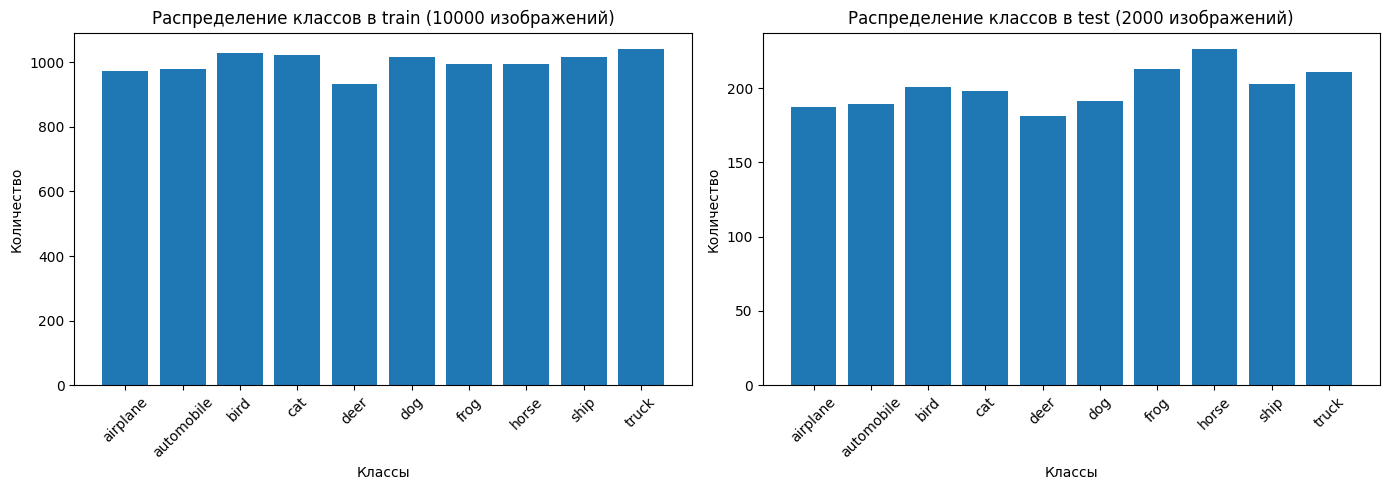

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_class_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

train_dist = get_class_distribution(train_ds_32_q)
test_dist = get_class_distribution(test_ds_32_q)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(class_names, [train_dist[i] for i in range(NUM_CLASSES)])
ax[0].set_title('Распределение классов в train (10000 изображений)')
ax[0].set_xlabel('Классы')
ax[0].set_ylabel('Количество')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(class_names, [test_dist[i] for i in range(NUM_CLASSES)])
ax[1].set_title('Распределение классов в test (2000 изображений)')
ax[1].set_xlabel('Классы')
ax[1].set_ylabel('Количество')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

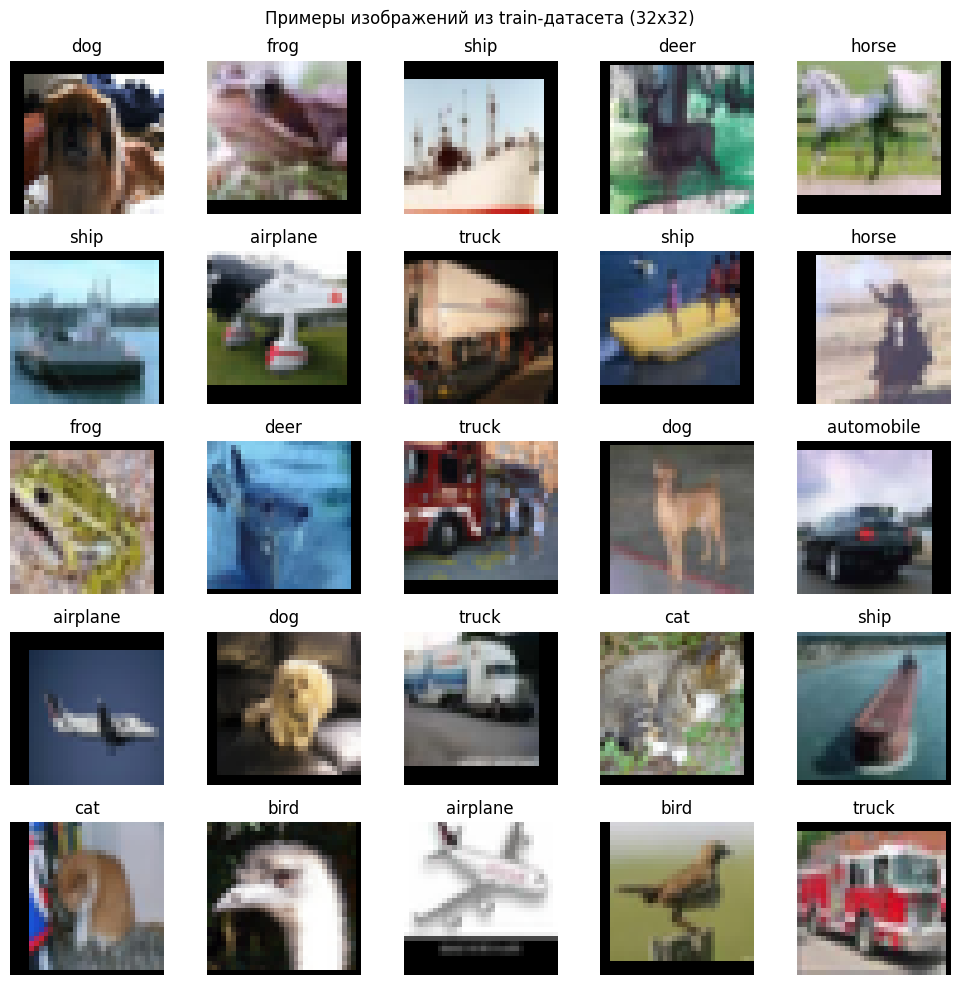

In [7]:
def denormalize(img, mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)):
    img = img.clone()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    return img

indices = np.random.choice(len(train_ds_32_q), 25, replace=False)
images = [train_ds_32_q[i][0] for i in indices]
labels = [train_ds_32_q[i][1] for i in indices]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(class_names[labels[i]])
    ax.axis('off')

plt.suptitle('Примеры изображений из train-датасета (32x32)')
plt.tight_layout()
plt.show()